# Part 1:

Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:  

To create the above dataframe:
-    The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
-    Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
-    More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
-    If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
-    Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
-    In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [1]:
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup as BS

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

soup = BS(urllib.request.urlopen(url).read(), 'html.parser')
tags = soup('table')[0]

In [3]:
columns = [a.text.strip('\n') for a in tags.find_all('th')]
columns

['Postcode', 'Borough', 'Neighbourhood']

Now, loop through each table row (tr) and get all of the table data (td), and append it to a list that can then be converted into a Pandas dataframe.

In [4]:
rows = []
for row in tags.find_all('tr')[1:] : rows.append([a.text.strip('\n') for a in row.find_all('td')])
df = pd.DataFrame(rows, columns=columns)
df.head(4)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village


Lastly, drop the rows with "Not assigned" in the Borough, fix the rows that need Borough copied to Neighbourhood, and then merge all of the Neighbourhoods in the same Postcode. 

In [5]:
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)

In [6]:
df['Neighbourhood'][df.Neighbourhood == 'Not assigned'] = df.Borough

In [7]:
df = pd.DataFrame(df.groupby(['Postcode','Borough'])['Neighbourhood'].unique().apply(lambda x: ', '.join(x))).reset_index()
df.head(6)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village


In [8]:
df.shape

(103, 3)

# Part 2

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

In [9]:
#!pip install geocoder
import geocoder # import geocoder

In [10]:
def get_lat_lon(postcode):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng

    print(postcode)
    return lat_lng_coords[0], lat_lng_coords[1]

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

Use the Geocoder package or the csv file to create the following dataframe:

In [11]:
df_latlon = pd.read_csv('Geospatial_Coordinates.csv')
df_latlon.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


In [12]:
df = pd.merge(df,df_latlon,left_on='Postcode',right_on='Postal Code')
df.drop(columns='Postal Code',inplace=True)
df.head(3)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


# Part 3

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

-    to add enough Markdown cells to explain what you decided to do and to report any observations you make.
-    to generate maps to visualize your neighborhoods and how they cluster together. 

Once you are happy with your analysis, submit a link to the new Notebook on your Github repository

In [13]:
import json # library to handle JSON files
import requests # library to handle requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

In [14]:
latitude = df.Latitude.mean()
longitude = df.Longitude.mean()
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.70460773398059, -79.39715291165048.


In [15]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

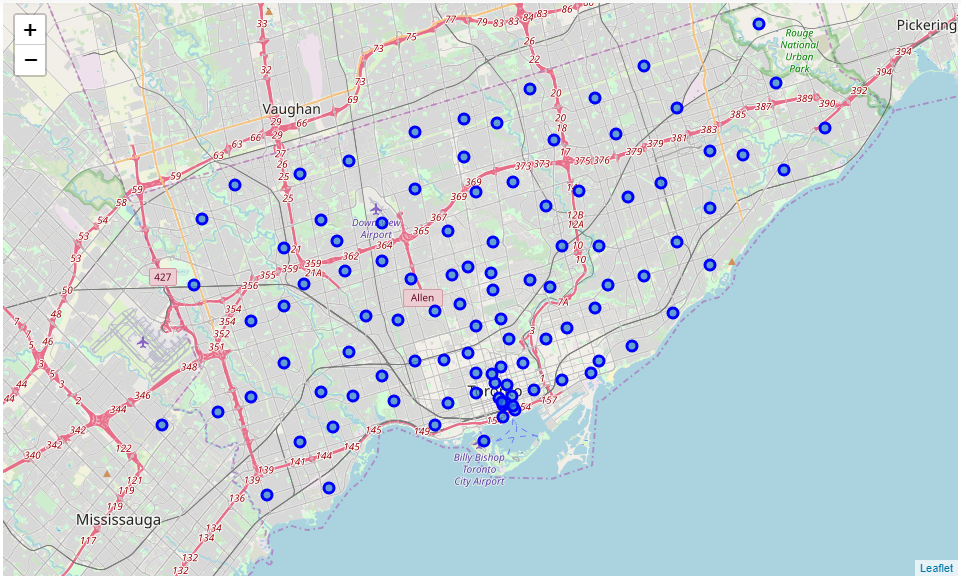

In [16]:
CLIENT_ID = 'removed' # your Foursquare ID
CLIENT_SECRET = 'removed' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
toronto_counts = toronto_venues.groupby('Neighborhood').count().sort_values('Venue',ascending=False)
toronto_counts

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
St. James Town,100,100,100,100,100,100
"Ryerson, Garden District",100,100,100,100,100,100
"Harbourfront East, Toronto Islands, Union Station",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Design Exchange, Toronto Dominion Centre",100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Stn A PO Boxes 25 The Esplanade,95,95,95,95,95,95
Central Bay Street,82,82,82,82,82,82


### Key decision: use only Neighborhoods that have more than 15 venues. Fewer than 15 is likely to be too small as to get a good idea of the concentration of venues there.

In [19]:
toronto_counts = toronto_counts[toronto_counts.Venue > 14].reset_index().Neighborhood
toronto_counts[:5]

0                             Adelaide, King, Richmond
1                                       St. James Town
2                             Ryerson, Garden District
3    Harbourfront East, Toronto Islands, Union Station
4               First Canadian Place, Underground city
Name: Neighborhood, dtype: object

In [20]:
toronto_data = toronto_venues[toronto_venues.Neighborhood.isin(toronto_counts)]

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_data['Neighborhood'] 

# move neighborhood column to the first column
this = toronto_onehot.columns.tolist()
this.remove('Neighborhood')
this.insert(0,'Neighborhood')
toronto_onehot = toronto_onehot[this]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
61,"Clarks Corners, Sullivan, Tam O'Shanter",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62,"Clarks Corners, Sullivan, Tam O'Shant

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.010000,0.000000,0.000000,0.000000,0.01,0.030000,0.010000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.070000,0.000000,0.000000,0.000000,0.00

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Cosmetics Shop,Asian Restaurant,Restaurant,Burger Joint,Bakery
1,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Ice Cream Shop,Pharmacy,Pizza Place,Middle Eastern Restaurant,Deli / Bodega,Restaurant,Bridal Shop,Diner,Sandwich Place
2,"Bedford Park, Lawrence Manor East",Sushi Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Pharmacy,Restaurant,Butcher,Pub,Café
3,Berczy Park,Coffee Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Bakery,Cheese Shop,Steakhouse,Farmers Market,Café,Restaurant
4,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Gym,Bakery,Grocery Store,Furniture / Home Store,Intersection,Italian Restaurant,Convenience Store


In [24]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 4, 4, 0, 0, 4, 1, 0, 0, 2, 2, 4, 3, 0, 4, 0, 5, 0, 0, 2, 0, 0,
       2, 4, 2, 5, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 4])

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [26]:
toronto_merged = df[df.Neighbourhood.isin(toronto_counts)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,3,Pharmacy,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Shopping Mall,Fried Chicken Joint,Thai Restaurant,Convenience Store,Intersection
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,5,Clothing Store,Coffee Shop,Fast Food Restaurant,Women's Store,Japanese Restaurant,Juice Bar,Toy / Game Store,Bakery,Tea Room,Bank
22,M2N,North York,Willowdale South,43.770120,-79.408493,4,Ramen Restaurant,Pizza Place,Sandwich Place,Coffee Shop,Café,Restaurant,Japanese Restaurant,Discount Store,Ice Cream Shop,Fast Food Restaurant
27,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,0,Gym,Asian Restaurant,Beer Store,Coffee Shop,Fast Food Restaurant,Discount Store,Dim Sum Restaurant,Concert Hall,Supermarket,Chinese Restaurant
28,M3H,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259,4,Coffee Shop,Ice Cream Shop,Pharmacy,Pizza Place,Middle Eastern Restaurant,Deli / Bodega,Restaurant,Bridal Shop,Diner,Sandwich Place
38,M4G,East York,Leaside,43.709060,-79.363452,4,Coffee Shop,Sporting Goods Shop,Sushi Restaurant,Burger Joint,Furniture / Home Store,Bank,Department Store,Dessert Shop,Fish & Chips Shop,Sports Bar
39,M4H,East York,Thorncliffe Park,43.705369,-79.349372,4,Indian Restaurant,Yoga Studio,Gym / Fitness Center,Pizza Place,Pharmacy,Park,Middle Eastern Restaurant,Liquor Store,Grocery Store,Supermarket
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Yoga Studio,Caribbean Restaurant,Dessert Shop,Pub
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,4,Fast Food Restaurant,Gym,Pet Store,Board Shop,Brewery,Sandwich Place,Burger Joint,Burrito Place,Pub,Coffee Shop
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Sandwich Place


In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+4))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], \
                                  toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

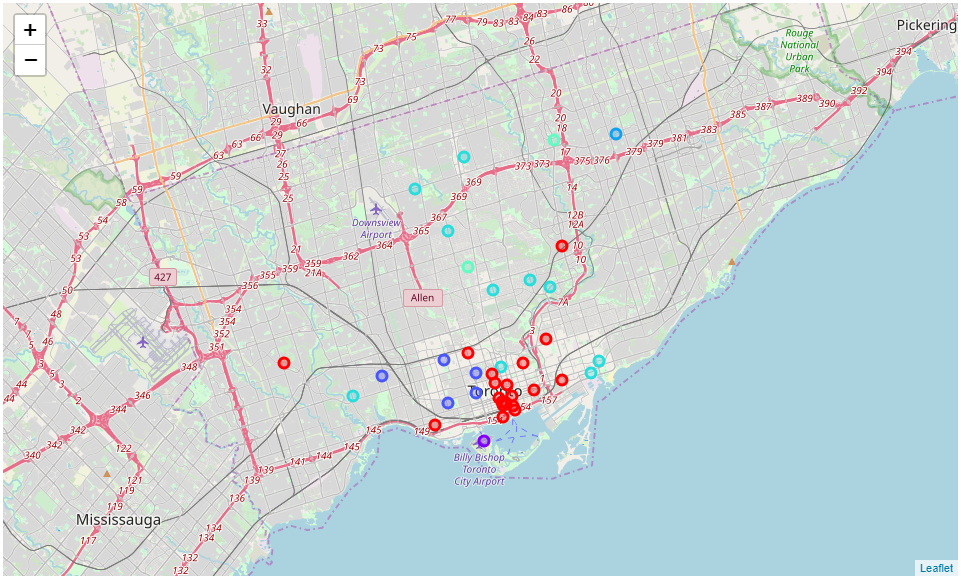

# Thanks for reviewing!